In [1]:
import numpy as np
import sys
sys.path.append('../../')
sys.path.append('../../pyfos/')
from pyfos.models.feedforward import build_feedforward
from pyfos.generic.optimizer import gd_optimizer
from pyfos.generic.regularizers import gaus_prior
from functools import partial 
from pyfos.tc.simple import  simple_tc
from pyfos.tc.cv import  cv_tc
from pyfos.hyperoptimizers.random_search import random_optimize
from pyfos.hyperoptimizers.no_optimize import no_optimize
import theano
%matplotlib inline
import matplotlib.pylab as plt
import random

In [2]:
matrix = np.load('../../../data/matrix.npy')
X, Y = np.load('../../../data/linearx.npy'), np.load('../../../data/lineary.npy')
X_train = X[:100]
Y_train = Y[:100]
X_test = X[100:]
Y_test = Y[100:]
lr = theano.shared(1.0)
alphas = theano.shared(np.array([1.0, 1.0]))
optimizer = partial(gd_optimizer, learning_rate=lr)
model_build = partial(build_feedforward,  structure = [2,1], nonlinearity=lambda x:x, log_alphas =alphas, bias=False)



In [3]:
def choicer():
    a1 = np.random.uniform(low=0.0, high=10.0)
    a2 = np.random.uniform(low=0.0, high=10.0)
    a1 = np.sqrt(10**(a1))
    a2 = np.sqrt(10**(a2))
    return np.log([a1,a2])
print choicer()    

[ 4.4167856   5.75108093]


In [4]:
bests = []
lr_ranges =   [10**(-2)]#[10**(-2),  0.5*10**(-2), 10**(-3), 0.5*10**(-3)]
lr.set_value(0.01)
for trial in range(1):
    print 'attemp'
    bests.append( random_optimize(partial(cv_tc, k =4,  batch_size=75), model_build, optimizer, 50, 10, X_train, Y_train,  [alphas] ,
     [choicer], verbose=999))
    print bests[-1].history[-1][-1]

attemp
hyperparams values: [  9.21239987  10.84761298]
trial 0 iteration 0, internal loss=-1357.06659361 time=0.00470089912415
score -137.843468314 vs best -inf
hyperparams values: [ 10.34228418   8.25684931]
trial 1 iteration 0, internal loss=-1355.60571425 time=0.00137782096863
score -137.843468314 vs best -137.843468314
hyperparams values: [ 6.41625678  4.90802037]
trial 2 iteration 0, internal loss=-1348.33085792 time=0.00157499313354
score -137.843468317 vs best -137.843468314
hyperparams values: [ 5.38095076  4.83567485]
trial 3 iteration 0, internal loss=-1347.22320637 time=0.00151014328003
score -137.843468325 vs best -137.843468314
hyperparams values: [ 4.72557514  1.37719194]
trial 4 iteration 0, internal loss=-1343.10934784 time=0.00143599510193
score -137.844051995 vs best -137.843468314
hyperparams values: [ 7.71586932  0.9135584 ]
trial 5 iteration 0, internal loss=-1345.63600848 time=0.00257992744446
score -137.847181997 vs best -137.843468314
hyperparams values: [ 0.623

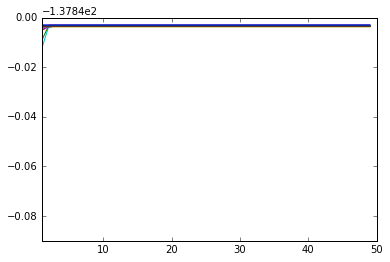

In [5]:

import cPickle
#with open('results_cv_rand.pckl','rb') as inp:
#    bests = cPickle.load(inp)

for b in bests:
    history = []
    for i in xrange(0, len(b.history)):
        
        best_value = max([h[1] for h in b.history[:i+1]])
        
        history.append(best_value)
    plt.plot(history)
#plt.ylim((-100, -80))
plt.xlim((1,50))

import cPickle
with open('results_cv_rand.pckl','wb') as out:
    cPickle.dump(bests, out)


In [12]:
bests[0].history[1]

([array([ 5.75646273,  1.15129255]), 0.01], array(-inf))

In [6]:
import theano.tensor as T
X = T.matrix()
result = []
models = []
predicts = []

for m in xrange(4):
    models.append(model_build(dataset_size=100))
    predict = models[m].predict_var(X)
    predicts.append(theano.function([X], predict))
for b in bests:
    scores = [b.history[i][1] for i in xrange(len(b.history))]
    best = np.argmax(scores)
    
    for m in xrange(4):
        #print b.history[best][2][m]
        models[m].params.set_value(b.history[best][2][m])
        result.append(np.mean((predicts[m](X_test)[:,0]-Y_test)**2))
        print result[-1]
    """
    bests.append( random_optimize(partial(cv_tc, k =4,  batch_size=75), model_build, optimizer, 50, 10, X_train, Y_train,  [alphas, lr] ,
     [alpha_ranges, lr_ranges], verbose=100))
    X = T.matrix()    
    model = model_build(dataset_size=100)
    
    
    """

print np.mean(result)
print np.std(result)

9.43914336962e-05
0.000124289005293
0.00129238139516
0.000242562662603
0.000779013165161
0.0102724095201
0.000206747922337
0.000140740432021
0.000132832862326
8.03570899432e-06
0.00749791590336
6.75131708431e-05
0.003461156779
0.000129756949236
0.000222773236192
0.000242858305185
7.31068395923e-06
0.000446081971565
2.10039527387e-05
0.00498557348802
0.000127393299536
0.000344975987004
0.00193295197259
1.12403631093e-05
0.00110372549492
0.000169369711448
8.88501579515e-05
0.000371158334277
5.25537631743e-05
0.000169072496902
6.99270861379e-05
0.000118547148409
0.00031077408314
0.000360231067999
0.00288808340749
0.00124557541155
0.0080222197081
0.000376121747349
0.000469794144926
0.000297591329386
0.00025797182711
0.00567665490985
2.50256902362e-05
2.5725705823e-05
3.9389787181e-05
0.000166544706471
0.000305865928779
5.53252217421e-05
0.000103489182896
0.000183979775623
0.000195866374435
0.000208717300477
2.41616115724e-05
0.000922038736434
0.000177551325219
0.00052912656389
0.0009803654

In [11]:
best_values = []
for b in bests:
    history = []
    for i in xrange(0, len(b.history)):
        
        best_value = max([h[1] for h in b.history[:i+1]])
        
        history.append(best_value)
        best_values.append(history[-1])
print np.mean(best_values)

-116.59428108


[([array([  31.6227766 ,  316.22776602]), 0.001], array(-127.64285224474986)),
 ([array([ 10.        ,   3.16227766]), 0.01], array(-162.5087255392545)),
 ([array([ 31.6227766 ,   3.16227766]), 0.01], array(-2.7627426873481633e+42)),
 ([array([  10.,  100.]), 0.005], array(-124.3719052719263)),
 ([array([  3.16227766,  31.6227766 ]), 0.01], array(-1.2198974168241432e+41)),
 ([array([ 316.22776602,    1.        ]), 0.001], array(-122.78697142872564)),
 ([array([ 1.,  1.]), 0.01], array(-2.048288202990528e+45)),
 ([array([ 316.22776602,   10.        ]), 0.02], array(nan)),
 ([array([   1.,  100.]), 0.005], array(-127.03124347465777)),
 ([array([  3.16227766,  31.6227766 ]), 0.01], array(-3.879875247817619e+79))]

In [33]:
for i in bests:
    print np.array(i.best_values[0])**2

[ 1.  1.]
[ 1.  1.]
[ 10.   1.]
[ 1.  1.]
[ 1.  1.]


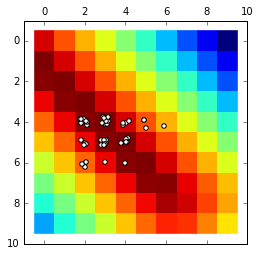

In [7]:
plt.matshow(matrix.T)
for i in bests:
    i = i.best_values[0]
    i = np.log10(np.exp(2*i))
    
    plt.scatter(i[0]+np.random.randn(1)*0.1,i[1]+np.random.randn(1)*0.1, c='w')

In [7]:
model = model_build(dataset_size=100)

In [9]:
import theano.tensor as T

In [28]:
X,Y = T.matrix(), T.vector()

In [29]:
cost = model.cost(X,Y)

In [35]:
f = theano.function([X,Y], cost)
print cost
f2 = theano.function([X,Y], T.grad(cost, model.params))
model.params.set_value([ 102.5926679 ,    0.23016751])

Elemwise{add,no_inplace}.0


In [36]:
#f(np.random.randn(100,2), np.random.randn(100))

f2(np.random.randn(100,2), np.random.randn(100))

array([ -1.02592668e+08,  -2.30167510e+05])